# Phishing Email Detection via Supervised Classification

The dataset used in this project comes from the following URL: https://www.kaggle.com/datasets/subhajournal/phishingemails. It contains email bodies labeled as either "safe" or "phishing".

In [1]:
#Module import zone

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score
from sklearn.preprocessing import LabelEncoder

In [2]:
#Importing CSV file into a dataFrame

df = pd.read_csv("Phishing_Email.csv")

#Cleaning Nan values

df.dropna(inplace=True)

In [3]:
#Visualization of its content

df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [4]:
#Delete the first unnecessary column

df = df.iloc[:, 1:]
df.head()

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


We choose TF-IDF vectorization to transform the raw email text into weighted value vectors that highlight the most important terms in an email relative to the entire corpus. This will help us better capture the words that differentiate phishing emails from legitimate ones.

In [5]:
#Initializing the TF-IDF vectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

#Transforming text into TF-IDF vectors

X = vectorizer.fit_transform(df['Email Text'])

#Initializing the target variable (email type)

y = df['Email Type']
le = LabelEncoder()
y_enc = le.fit_transform(y)

In [6]:
#Checking class balance

y.value_counts()

Safe Email        11322
Phishing Email     7312
Name: Email Type, dtype: int64

Our dataset shows a moderate imbalance between email types (around 60%/40%). This level of imbalance remains acceptable for binary classification, especially since metrics like the F1-score and AUC are used to evaluate model performance in a balanced way.

In [7]:
#Splitting into train/test sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

In this project, several classification models were selected due to their proven performance and their ability to handle textual datasets:

- Logistic Regression :

A simple and interpretable model, logistic regression is effective for binary classification problems like ours.

- Random Forest :

An ensemble model that combines multiple decision trees and whose robustness helps reduce overfitting.

- Naive Bayes :

A probabilistic model that performs well in text classification tasks like ours.

- Support Vector Machine (SVM) :

A powerful model chosen here for its effectiveness in binary classification, particularly in cases involving imbalanced data.

In [8]:
#Dictionary of models with their parameter grids to optimize

models_params = {
    
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            'C': np.logspace(-4, 3, 10),
            'penalty': ['l2'],
            'solver': ['liblinear', 'lbfgs']}},
    
    "SVC": {
        "model": SVC(),
        "params": {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}},
    
    "MultinomialNB": {
        "model": MultinomialNB(),
        "params": {
            'alpha': [0.01, 0.1, 1.0, 10],
            'fit_prior': [True, False]}},
    
    "RandomForestClassifier": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2']}}
    
}

To optimize the performance of the chosen models, we will use GridSearchCV to determine the hyperparameters that maximize their performance. We will then select the optimal models to choose the one that best predicts the nature of the emails.

In [9]:
#Dictionary to store the optimized models

best_models = {}
cv_results = {}

#Loop over each model

for name, model in models_params.items():
    print(f"Optimizing {name}...")

    #GridSearch for hyperparameters
    start = time.time()
    grid = GridSearchCV(model["model"], model["params"], cv=3, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    duration = time.time() - start
    
    #Best model
    best_model = grid.best_estimator_
    best_models[name] = best_model
    
    print(f"Best parameters: {grid.best_params_}")
    
    #Evaluation via cross_val_score
    scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')
    mean_score = scores.mean()
    std_score = scores.std()
    cv_results[name] = (mean_score, std_score)

    print(f"Average F1 score: {mean_score:.4f} ± {std_score:.4f}")
    if duration < 60:
        print(f"Training time: {int(duration)} seconds.\n")
    else:
        print(f"Training time: {int(duration // 60)} minutes and {int(duration - (duration // 60) * 60)} seconds.\n")

Optimizing LogisticRegression...
Best parameters: {'C': 4.641588833612782, 'penalty': 'l2', 'solver': 'liblinear'}
Average F1 score: 0.9735 ± 0.0021
Training time: 11 seconds.

Optimizing SVC...
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Average F1 score: 0.9754 ± 0.0023
Training time: 9 minutes and 40 seconds.

Optimizing MultinomialNB...
Best parameters: {'alpha': 0.1, 'fit_prior': False}
Average F1 score: 0.9657 ± 0.0020
Training time: 2 seconds.

Optimizing RandomForestClassifier...
Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Average F1 score: 0.9713 ± 0.0025
Training time: 2 minutes and 34 seconds.



After hyperparameter optimization with GridSearchCV, the models were evaluated using cross-validation: the best models, Logistic Regression, Random Forest, and SVM, achieve average F1 scores greater than 0.97. The Multinomial Naive Bayes model appears slightly less performant but remains competitive. Overall, our models seem relatively stable, with low variance observed. Let’s look at the area under the ROC and PR curves (AUC) to confirm our intuitions and demonstrate our models’ ability to distinguish between classes despite a slight imbalance.

In [10]:
print("Area under curve (AUC) :")
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    auc_roc = roc_auc_score(y_test, y_proba)
    auc_pr = average_precision_score(y_test, y_proba)
    
    print(f"{name:<23} | ROC: {auc_roc:.3f} | PR: {auc_pr:.3f}")

Area under curve (AUC) :
LogisticRegression      | ROC: 0.998 | PR: 0.998
SVC                     | ROC: 0.993 | PR: 0.996
MultinomialNB           | ROC: 0.994 | PR: 0.996
RandomForestClassifier  | ROC: 0.995 | PR: 0.997


The F1-scores of our models are overall very high, suggesting that they can effectively predict the nature of an email based on its content. Additionally, the AUC values are also very close to 1 for all models, confirming their excellent ability to distinguish between phishing and legitimate emails, despite the slight class imbalance. However, this analysis does not yet allow us to clearly select one model over another...

To address this, we will focus on confusion matrices: they allow us to examine the nature of the errors made by each model (false positives and false negatives), helping in decision-making based on the priorities of the problem (minimizing certain types of errors).

In [11]:
#Dictionary to store the confusion matrices

confusion_matrices = {}

#Loop over each model

for name, model in best_models.items():
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm
    
    print(f"Confusion matrix for {name}:\n{cm}")

Confusion matrix for LogisticRegression:
[[1435   27]
 [  65 2200]]
Confusion matrix for SVC:
[[1436   26]
 [  55 2210]]
Confusion matrix for MultinomialNB:
[[1425   37]
 [  97 2168]]
Confusion matrix for RandomForestClassifier:
[[1416   46]
 [  62 2203]]


Overall, under equivalent constraints, a model that minimizes both false positives and false negatives will naturally be preferred. However, when certain models excel at reducing one type of error at the expense of the other, the choice of model will then depend on the decision-maker’s preferences, particularly their level of tolerance or aversion to each type of error.

The model SVC minimizes both "false positive" and "false negative" errors, here is its confusion matrix:


<Figure size 600x400 with 0 Axes>

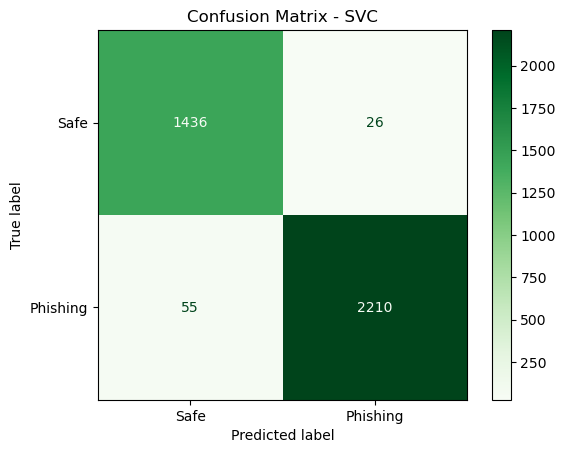

In [12]:
min_fp, mat_fp = len(df), np.zeros((2, 2))
min_fn, mat_fn = len(df), np.zeros((2, 2))

for cm in confusion_matrices.values():
    if cm[0][1] < min_fp:
        min_fp = cm[0][1]
        mat_fp = cm
    if cm[1][0] < min_fn:
        min_fn = cm[1][0]
        mat_fn = cm

if np.array_equal(mat_fp, mat_fn):
    for model, cm in confusion_matrices.items():
        if np.array_equal(cm, mat_fp):
            best_model = model
    print(f'The model {best_model} minimizes both "false positive" and "false negative" errors, here is its confusion matrix:')
    disp = ConfusionMatrixDisplay(confusion_matrix=mat_fn, display_labels=["Safe", "Phishing"])
    plt.figure(figsize=(6, 4))
    disp.plot(cmap="Greens", values_format='d')
    plt.title(f"Confusion Matrix - {best_model}")
    plt.grid(False)
    plt.show()
else:
    print("No model minimizes both types of errors, a trade-off on the importance of each type of error is required.")

Although the SVC model provides excellent results by minimizing both types of errors, its usage may be limited by practical considerations. Indeed, we observed that its training time is 6 to nearly 400 times longer than that of the other models (6 minutes versus 1 second to 1 minute for the others). It is therefore worthwhile to evaluate the performance of the other models in this context.

In [13]:
#Deleting SVC

del confusion_matrices["SVC"]

At this stage, after excluding the SVC model for practical reasons, none of the remaining models manage to simultaneously minimize both types of errors, and therefore, each model presents a different trade-off.
To guide decision-making in this context, we introduce a preference function that weights the relative importance of false negatives and false positives. This criterion, parameterized by a weightv $p \in [0, 1]$, allows for the selection of the model best suited to the operational priorities of the decision-maker.

For example, a system administrator concerned with security might prefer to minimize false negatives ($p>0.5$), that is, avoid letting a phishing email pass through, even if it means wrongly classifying some legitimate emails as suspicious. In contrast, a customer service team might seek to minimize false positives ($p<0.5$) in order to avoid unnecessarily blocking valid communications with users. Finally, a neutral decision-maker or one without specific preference might simply want to minimize the total number of errors ($p=0.5$), by balancing both types of errors fairly.

The decision-maker will then aim to minimize their cost function relative to the number of errors according to their type (FP: False Positives, weighted by $1-p$ and FN: False Negatives, weighted by $p$). In the case of a linear cost function, we can define $ f_p(FN,FP) = p \times FN + (1-p) \times FP $. This function is then evaluated for each model to identify the one that minimizes the overall cost according to the decision-maker's preferences.

In [14]:
def cf(confusion_matrices, p):
    if 0 <= p <= 1: 
        best_model = None
        best_cm = None
        min_score = float('inf')

        for name, cm in confusion_matrices.items():
            fp = cm[0, 1]  #False positives
            fn = cm[1, 0]  #False negatives
            score = p * fn + (1 - p) * fp  #Cost

            if score < min_score:
                min_score = score
                best_model = name
                best_cm = cm

        print(f"Best model for p={p}: {best_model}")
        disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=["Safe", "Phishing"])
        plt.figure(figsize=(6, 4))
        disp.plot(cmap="Greens", values_format='d')
        plt.title(f"Confusion Matrix - {best_model}")
        plt.grid(False)
        plt.show()

        return best_model

Best model for p=0.95: RandomForestClassifier


<Figure size 600x400 with 0 Axes>

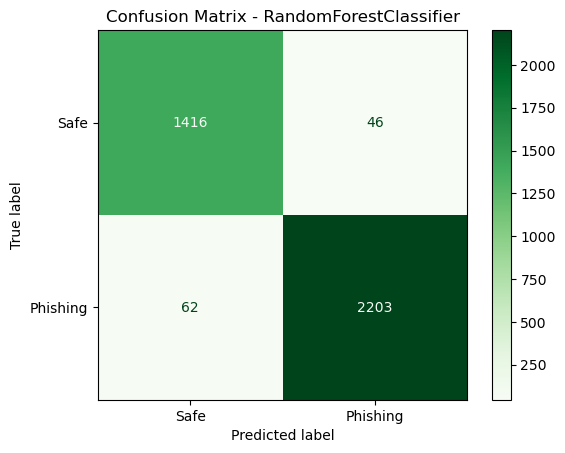

'RandomForestClassifier'

In [15]:
cf(confusion_matrices, p=0.95)

In the case of a strong aversion to the risk of non-detection (predicting a phishing email as safe), with $p > 0.5$, the Random Forest Classifier model is preferred. It is indeed the one that minimizes this type of error.

Best model for p=0.5: LogisticRegression


<Figure size 600x400 with 0 Axes>

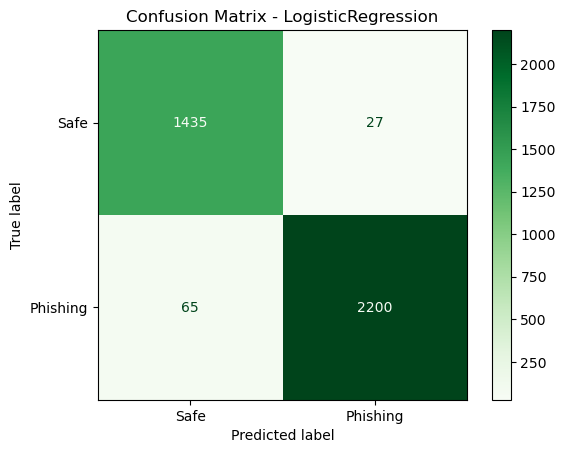

'LogisticRegression'

In [16]:
cf(confusion_matrices, p=0.5)

On the other hand, a decision-maker indifferent to the type of error preferred, with $ p = 0.5 $, will prefer a Logistic Regression model, which makes the fewest errors:

In [17]:
for name, cm in confusion_matrices.items():
    errors = cm[0, 1] + cm[1, 0]
    print(f"Number of errors for {name}: {errors}")

Number of errors for LogisticRegression: 92
Number of errors for MultinomialNB: 134
Number of errors for RandomForestClassifier: 108


Best model for p=0.05: LogisticRegression


<Figure size 600x400 with 0 Axes>

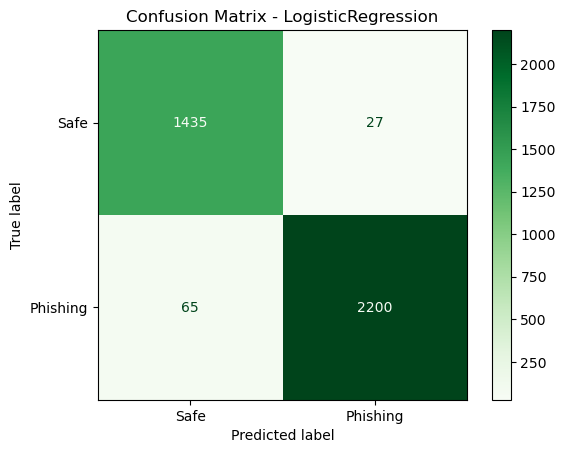

'LogisticRegression'

In [18]:
cf(confusion_matrices, p=0.05)

Finally, for a strong aversion to the risk of false positives (predicting a safe email as phishing), with $p < 0.5$, the Logistic Regression model is preferred again.

It could then be interesting to plot, for each model and according to the evolution of the parameter $p$, the cost function curve to facilitate decision-making.

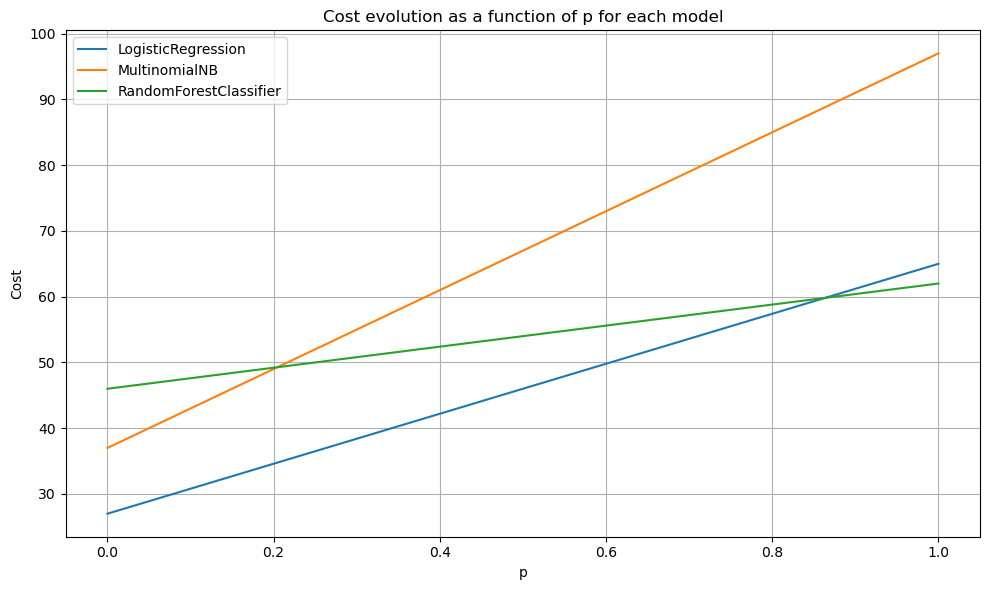

In [19]:
val_p = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 6))

for name, cm in confusion_matrices.items():
    fn = cm[1][0]
    fp = cm[0][1]
    scores = [p * fn + (1 - p) * fp for p in val_p]
    plt.plot(val_p, scores, label=name)

plt.xlabel("p")
plt.ylabel("Cost")
plt.title("Cost evolution as a function of p for each model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The MultinomialNB model seems to never be optimal: under equivalent constraints, the Logistic Regression model will always be preferred. Indeed, it minimizes each error compared to the former, and thus the associated cost function. We will therefore remove it to finalize our analysis.

In [20]:
#Deleting SVC

del confusion_matrices["MultinomialNB"]

In [21]:
#Initialization of variables containing the confusion matrices of our two models

cmlr = list(confusion_matrices.values())[0]  #Confusion matrix of the Logistic Regression model
cmrfc = list(confusion_matrices.values())[1]  #Confusion matrix of the Random Forest model

We are now left with only two models to analyze: Logistic Regression and Random Forest. We will determine the value of $p$ that makes a decision-maker indifferent between choosing one model over the other. To do this, we will solve for $p$ in the equation:

$$
FN_{\text{LogisticRegression}} \times p + FP_{\text{LogisticRegression}} \times (1-p) = FN_{\text{RandomForest}} \times p + FP_{\text{RandomForest}} \times (1-p)
$$

This equation is equivalent to :

$$
p = \frac{FP_{\text{RF}} - FP_{\text{LR}}}{(FN_{\text{LR}} - FP_{\text{LR}}) - (FN_{\text{RF}} - FP_{\text{RF}})}
$$

In [22]:
p = (cmrfc[0][1] - cmlr[0][1])/((cmlr[1][0] - cmlr[0][1]) - (cmrfc[1][0] - cmrfc[0][1]))

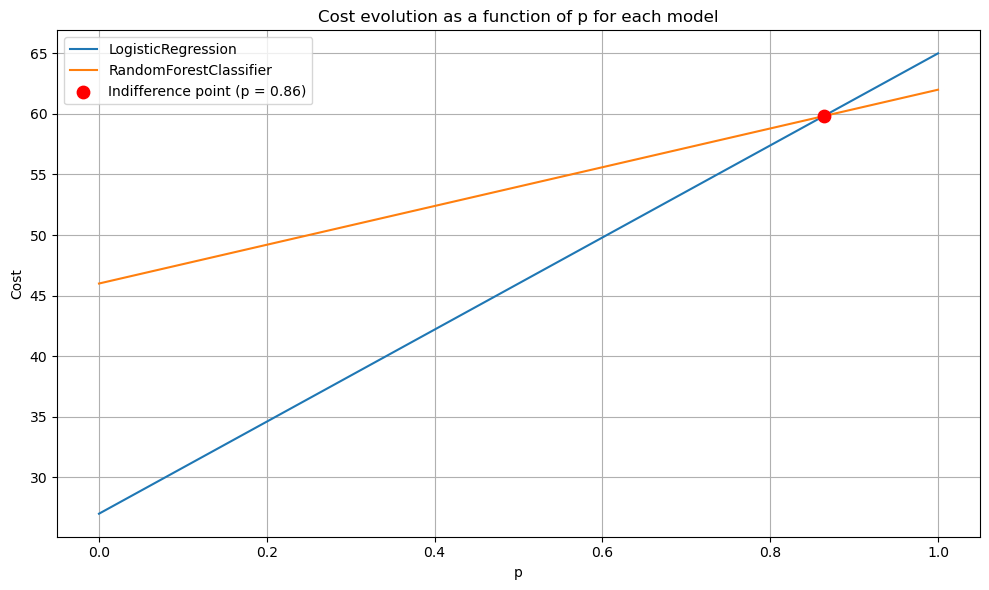

In [23]:
val_p = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 6))

for name, cm in confusion_matrices.items():
    fn = cm[1][0]
    fp = cm[0][1]
    scores = [p * fn + (1 - p) * fp for p in val_p]
    plt.plot(val_p, scores, label=name)

plt.scatter(p, p * fn + (1 - p) * fp, c='r', s=80, zorder=5, label=f"Indifference point (p = {round(p, 2)})")
plt.xlabel("p")
plt.ylabel("Cost")
plt.title("Cost evolution as a function of p for each model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Our graphical representation highlights that, in our case, only a decision-maker with a very strong aversion to the risk of non-detection ($ p > 0.86 $) will prefer to use the Random Forest model over the Logistic Regression model. Other decision-makers, less averse to this risk, will prefer the Logistic Regression model ($ p < 0.86 $) or will be indifferent between choosing one or the other ($ p = 0.86 $).

For this model, it is relevant to examine the words that have the greatest influence on the prediction of an email’s nature, which we will then put to the test on two personally received emails: one phishing email and one legitimate email.

In [24]:
lr = best_models['LogisticRegression']

In [25]:
#Checking which label corresponds to which class

print(le.classes_)
print(lr.classes_)

['Phishing Email' 'Safe Email']
[0 1]


In [26]:
#Retrieval of words and associated coefficients

coefficients = lr.coef_[0]
words = vectorizer.get_feature_names_out()

#Words associated with phishing (negative coefficients)

top_phishing = sorted(zip(coefficients, words))[:10]

#Words associated with safe emails (positive coefficients)

top_safe = sorted(zip(coefficients, words), reverse=True)[:10]

print("Top 10 words associated with Phishing:")
print(pd.DataFrame(top_phishing, columns=["Coefficient", "Word"]))

print("\nTop 10 words associated with Safe Emails:")
print(pd.DataFrame(top_safe, columns=["Coefficient", "Word"]))

Top 10 words associated with Phishing:
   Coefficient       Word
0    -7.340211       2005
1    -6.821041  sightings
2    -5.668773     remove
3    -5.352274       2004
4    -5.001971      money
5    -4.958564       site
6    -4.794825      click
7    -4.244875    removed
8    -4.157453      email
9    -4.083382        low

Top 10 words associated with Safe Emails:
   Coefficient        Word
0    11.241882       enron
1     8.109236         url
2     7.846094       wrote
3     6.961509        2002
4     6.754695      thanks
5     6.507487    language
6     5.932066  university
7     5.559034         edu
8     5.460248       vince
9     5.229014      louise


In [27]:
#Personal emails

email_phishing = ["It’s Cinco de Mayo — time to party! Celebrate by growing your Instagram with a huge 35% OFF our real IG followers, likes, and views.Use code CINCO35 at checkout. Hurry, fiesta ends tonight!"]
email_safe = ["An intervention by the residence’s Internet service provider will take place next week, on Monday, May 5th, 2025, starting at 10 a.m. Please ensure the technician has access. The intervention will be brief and will help improve the building’s Wi-Fi connection. Please read the attached document. For any further information, we remain at your disposal. Best regards, Imane"]

#Transform the text into TF-IDF vectors (using the same pre-trained vectorizer)

X_email_phishing = vectorizer.transform(email_phishing)
X_email_safe = vectorizer.transform(email_safe)

#Predictions

prediction_phishing = lr.predict(X_email_phishing)
prediction_safe = lr.predict(X_email_safe)

#Display results

pred_label_phishing = le.inverse_transform(prediction_phishing)[0]
print(f"The phishing email is classified as {pred_label_phishing}")
pred_label_safe = le.inverse_transform(prediction_safe)[0]
print(f"The safe email is classified as {pred_label_safe}")

The phishing email is classified as Phishing Email
The safe email is classified as Safe Email
